<a href="https://colab.research.google.com/github/woodychang0611/EMNIST/blob/master/EMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare Environment
If running on colab mount google drive, otherwise use 200g drive from NCCU GPU cloud

In [0]:
import sys
import os
if ('google.colab' in sys.modules):
  from google.colab import drive
  drive.mount('/content/gdrive')
  gdrive_root = 'gdrive/My Drive/Deep_Learning/'
  dataset_path = os.path.join(gdrive_root,'Dataset')
else:
  dataset_path = '200g/Dataset'
  pass

if not os.path.exists(dataset_path):
  raise Exception(f'dataset_path "{dataset_path}"" does not exist')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Load Dataset

In [0]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim
import torch.autograd
import torchvision
import torchvision.transforms
import numpy as np
from matplotlib import pyplot as plt
import datetime

trans = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5,), (1.0,))])
use_cuda = None
if torch.cuda.is_available():
  print("CUDA available")
  use_cuda = True
else:
  print ("CUDA not available")
  use_cuda = False
if os.path.exists(dataset_path):
  train_set = torchvision.datasets.EMNIST(root=dataset_path, transform=trans,train =True, split="byclass",download=True)
  test_set = torchvision.datasets.EMNIST(root=dataset_path, transform=trans,split="byclass", train =False)
  print (f'Dataset loaded, {train_set.__len__():,} training set, {test_set.__len__():,} testing set')
else:
  print (f'dataset_path "{dataset_path}" not found')
  exit(0)

batch_size = 128

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)


CUDA available
Dataset loaded, 697,932 training set, 116,323 testing set


# Common Functions

In [0]:
ceriation = nn.CrossEntropyLoss()
def apply_model(model,x,target):
    x, target = torch.autograd.Variable(x), torch.autograd.Variable(target)
    out = model(x)
    loss = torch.nn.CrossEntropyLoss()(out, target)
    return out,loss
def plot_graph(name,train_loss,test_loss):
  fig, ax = plt.subplots()
  ax.plot(train_loss,label='train loss')
  ax.plot(test_loss,label='test loss')  
  ax.set(xlabel='epoch', ylabel='Loss',title=name)
  plt.legend()
  plt.show()


# Define CNN

In [0]:
#CNN
class ConvolutioNeuralNetwork (torch.nn.Module):
    def __init__(self,dropout=0):
        super(ConvolutioNeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 100)
        self.fc3 = nn.Linear(100, 62)
        self.dropout=dropout
    def forward(self, x):      
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.dropout(x,p = self.dropout)
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.dropout(x,p = self.dropout)
        x = F.relu(self.fc1(x))     
        x = F.relu(self.fc2(x))
        x = F.dropout(x,p = self.dropout)
        x = self.fc3(x)
        return x

2020-03-29 13:32:47.312129
model:Dropout Rate:0.20, parameter:482,432
==>>> epoch: 0, batch index: 5453, train loss: 0.479508
==>>> epoch: 0, batch index: 909, test loss: 0.475563, acc: 0.828
==>>> epoch: 1, batch index: 5453, train loss: 0.441738
==>>> epoch: 1, batch index: 909, test loss: 0.429996, acc: 0.843
==>>> epoch: 2, batch index: 5453, train loss: 0.435806
==>>> epoch: 2, batch index: 909, test loss: 0.411873, acc: 0.852
==>>> epoch: 3, batch index: 5453, train loss: 0.400857
==>>> epoch: 3, batch index: 909, test loss: 0.404877, acc: 0.854
==>>> epoch: 4, batch index: 5453, train loss: 0.408870
==>>> epoch: 4, batch index: 909, test loss: 0.398082, acc: 0.855
==>>> epoch: 5, batch index: 5453, train loss: 0.363713
==>>> epoch: 5, batch index: 909, test loss: 0.391856, acc: 0.859
==>>> epoch: 6, batch index: 5453, train loss: 0.398321
==>>> epoch: 6, batch index: 909, test loss: 0.387562, acc: 0.861
==>>> epoch: 7, batch index: 5453, train loss: 0.380082
==>>> epoch: 7, batc

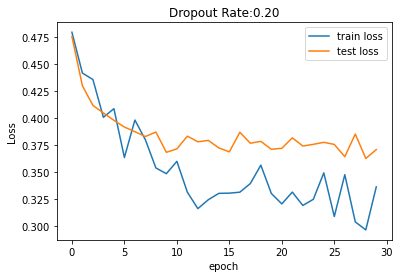

In [0]:
models = tuple (map(lambda p:(f"Dropout Rate:{p:.2f}", ConvolutioNeuralNetwork(dropout=p)),(0.2,)))
sample_limit = 100000000
for (name, model) in models:
  print(datetime.datetime.now())
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  parameter_len = sum(p.numel() for p in model.parameters() if p.requires_grad)
  print(f'model:{name}, parameter:{parameter_len:,}')
  train_loss=[]
  test_loss=[]
  if use_cuda:
    model.cuda()
  for epoch in range(30):
    # training
    ave_loss = 0
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        if use_cuda:
            x, target = x.cuda(), target.cuda()
        out,loss = apply_model (model,x,target)
        ave_loss = ave_loss * 0.9 + loss.data* 0.1
        loss.backward()
        optimizer.step()
        if (batch_idx+1) == len(train_loader) or batch_idx >sample_limit:
            print (f'==>>> epoch: {epoch}, batch index: {batch_idx+1}, train loss: {ave_loss:.6f}')
            break
    train_loss.append(ave_loss)
    # testing
    correct_cnt, ave_loss = 0, 0
    total_cnt = 0
    for batch_idx, (x, target) in enumerate(test_loader):
        if use_cuda:
          x, target = x.cuda(), target.cuda()      
        out,loss = apply_model (model,x,target)        
        _, pred_label = torch.max(out.data, 1)
        total_cnt += x.data.size()[0]
        correct_cnt += (pred_label == target.data).sum()
        # smooth average
        ave_loss = ave_loss * 0.9 + loss.data * 0.1
        if (batch_idx) == len(test_loader)-1 or batch_idx >sample_limit:
            print (f'==>>> epoch: {epoch}, batch index: {batch_idx+1}, test loss: {ave_loss:.6f}, acc: {correct_cnt * 1.0 / total_cnt:.3f}')
            break
    test_loss.append(ave_loss)
  plot_graph(name,train_loss,test_loss)    